# Species Distribution Modellin in Python

In [1]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import geowombat as gw # remote sensing and spatial operations
import geopandas as gpd

# import dask
# from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
import os
import glob
from tqdm.notebook import tqdm

In [2]:
%matplotlib inline

In [3]:
import os
os.getcwd()

'/home/rvalavi/Documents/SDM_with_Python'

### *Listing raster layers*

In [4]:
rlist = glob.glob("Rasters/*.tif")
rlist

['Rasters/tempann.tif',
 'Rasters/vegsys.tif',
 'Rasters/solrad.tif',
 'Rasters/topo.tif',
 'Rasters/raindq.tif',
 'Rasters/cti.tif',
 'Rasters/mi.tif',
 'Rasters/soildepth.tif',
 'Rasters/rugged.tif',
 'Rasters/rainann.tif',
 'Rasters/soilfert.tif',
 'Rasters/tempmin.tif',
 'Rasters/disturb.tif']

In [77]:
names = [i[8:-4] for i in rlist]
names[0:3]

['tempann', 'vegsys', 'solrad']

CPU times: user 231 ms, sys: 28.7 ms, total: 260 ms
Wall time: 248 ms


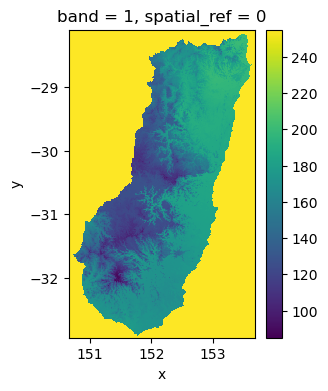

In [6]:
%%time
plt.figure(figsize=(3,4))
tempann = rxr.open_rasterio('Rasters/tempann.tif', chunks={'x':1689, 'y':1797})
tempann[0::10, 0::10].plot()

### *Reading occurrence points*

In [7]:
# import point data
points = pd.read_csv("Records/train_po/NSWtrain_po.csv")
occ = points[points["spid"] == "nsw14"]
occ = occ[['occ', 'x', 'y']]
occ.shape

(315, 3)

In [8]:
geo_occ = gpd.GeoDataFrame(occ, geometry=gpd.points_from_xy(occ.x, occ.y))
geo_occ.head()

,occ,x,y,geometry
1149,1,153.4879,-28.1642,POINT (153.48790 -28.16420)
1150,1,153.4838,-28.1651,POINT (153.48380 -28.16510)
1151,1,153.4930,-28.1696,POINT (153.49300 -28.16960)
1152,1,152.5070,-28.2522,POINT (152.50700 -28.25220)
1153,1,152.4990,-28.2567,POINT (152.49900 -28.25670)


### *Generating random background samples*

In [52]:
from shapely.geometry import Point

def random_points_in_polygon(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds.values[0]
    x = np.random.uniform(minx, maxx, number)
    y = np.random.uniform(miny, maxy, number)
    
    df = pd.DataFrame()
    df['geometry'] = list(zip(x,y))
    df['geometry'] = df['geometry'].apply(Point)
    gdf_points = gpd.GeoDataFrame(df, geometry='geometry')
    
    Sjoin = gpd.tools.sjoin(gdf_points, polygon, predicate="within", how='left')

    # Keep points in "myPoly"
    pnts_in_poly = gdf_points[Sjoin.index_right==0]

    return pnts_in_poly

In [53]:
# read the border file
border = gpd.read_file("nsw.gpkg")

In [54]:
bg = random_points_in_polygon(border, 1_000)
bg.shape

(506, 1)

In [55]:
bg['occ'] = 0
bg.head()

,geometry,occ
1,POINT (151.83963 -32.51066),0
3,POINT (152.56233 -29.00316),0
6,POINT (151.84881 -32.39395),0
9,POINT (152.47296 -31.44974),0
12,POINT (152.19007 -32.27383),0


<AxesSubplot:>

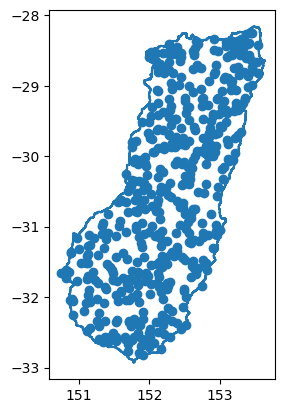

In [56]:
fig, ax = plt.subplots()

border.boundary.plot(ax=ax)
bg.plot(ax=ax)

### *Combine occurrence and background sample*

In [81]:
samples = pd.concat([geo_occ[['occ', 'geometry']], bg])
samples.head()

,occ,geometry
1149,1,POINT (153.48790 -28.16420)
1150,1,POINT (153.48380 -28.16510)
1151,1,POINT (153.49300 -28.16960)
1152,1,POINT (152.50700 -28.25220)
1153,1,POINT (152.49900 -28.25670)


In [67]:
samples.groupby('occ').count()

,geometry
occ,
0,506
1,315


In [82]:
# save to file
samples.to_file('occurrence.gpkg', driver='GPKG', layer='name')

### *Extrating raster values for model training*

In [84]:
%%time
with gw.open(rlist, chunks=(1689, 1797)) as src:
    train_gdf = src.gw.extract('occurrence.gpkg', time_names=names, band_names=None)

CPU times: user 1.12 s, sys: 120 ms, total: 1.24 s
Wall time: 929 ms


In [86]:
train_gdf

,occ,geometry,id,tempann_1,vegsys_1,solrad_1,topo_1,raindq_1,cti_1,mi_1,soildepth_1,rugged_1,rainann_1,soilfert_1,tempmin_1,disturb_1
0,1,POINT (153.48790 -28.16420),0,200,5,89,-1,216,1339,88,1139,11,1590,2,85,3
1,1,POINT (153.48380 -28.16510),1,199,5,89,-3,216,1439,88,1149,15,1592,2,84,3
2,1,POINT (153.49300 -28.16960),2,200,5,89,-1,222,1629,89,1159,1,1594,2,86,3
3,1,POINT (152.50700 -28.25220),3,159,2,86,-3,222,1259,92,1080,28,1580,2,45,2
4,1,POINT (152.49900 -28.25670),4,158,2,88,-3,222,1279,91,1110,51,1568,2,44,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
816,0,POINT (152.13630 -30.79730),816,163,1,89,36,126,1079,81,910,116,880,2,31,1
817,0,POINT (152.29045 -28.56116),817,176,7,97,-16,126,1509,56,990,24,866,2,36,3
818,0,POINT (152.30402 -29.87501),818,172,4,95,16,132,1119,57,899,36,914,2,41,3
819,0,POINT (152.11697 -30.29578),819,116,9,89,14,144,1179,79,1019,23,896,2,0,4


<AxesSubplot:>

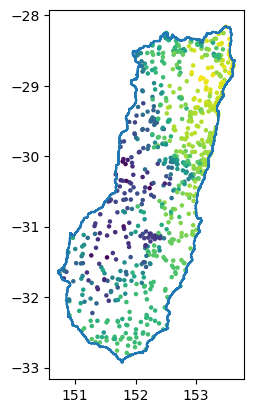

In [102]:
base = border.boundary.plot()
train_gdf.plot(ax=base, column='tempann_1', markersize=5)

In [103]:
train_df = train_gdf[['tempann_1', 'solrad_1', 'topo_1', 'raindq_1', 'cti_1', 'mi_1', 'soildepth_1', 'rugged_1', 'rainann_1', 'soilfert_1', 'tempmin_1']]
col_names = {i:i[0:-2] for i in train_df.columns}
X = train_df.rename(columns=col_names)
X.head()

,tempann,solrad,topo,raindq,cti,mi,soildepth,rugged,rainann,soilfert,tempmin
0,200,89,-1,216,1339,88,1139,11,1590,2,85
1,199,89,-3,216,1439,88,1149,15,1592,2,84
2,200,89,-1,222,1629,89,1159,1,1594,2,86
3,159,86,-3,222,1259,92,1080,28,1580,2,45
4,158,88,-3,222,1279,91,1110,51,1568,2,44


In [104]:
y = train_gdf['occ']
y.unique()

array([1, 0])

# Modelling test with GeoWombat

In [17]:
from geowombat.data import l8_224078_20200518, l8_224078_20200518_polygons

In [18]:
from geowombat.ml import fit, predict, fit_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

In [19]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn_xarray.model_selection import CrossValidatorWrapper

# Test on the NSW data

## Creating random background samples

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest

(502, 1)

In [25]:
bg['occ'] = 0
bg.head()

,geometry,occ
3,POINT (152.51590 -29.54392),0
4,POINT (152.62123 -30.00165),0
7,POINT (151.71931 -30.21674),0
8,POINT (152.55970 -31.41991),0
9,POINT (152.79894 -28.40694),0


In [26]:
labels = pd.concat([geo_occ[['occ', 'geometry']], bg])
labels.to_file('occurrence.gpkg', driver='GPKG', layer='name')
labels.head()

,occ,geometry
1149,1,POINT (153.48790 -28.16420)
1150,1,POINT (153.48380 -28.16510)
1151,1,POINT (153.49300 -28.16960)
1152,1,POINT (152.50700 -28.25220)
1153,1,POINT (152.49900 -28.25670)


In [27]:
labels.crs is None

True

In [28]:
labels = labels.set_crs('epsg:32755')
labels.crs is None

False

In [29]:
model_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier()) # SelectKBest(k=3), 

In [30]:
cv = CrossValidatorWrapper(KFold(n_splits=5))

In [31]:
params = {'n_neighbors': [4, 6, 8,]}

In [32]:
gridsearch = GridSearchCV(model_pipeline, cv=cv, scoring='balanced_accuracy', param_grid=params)

In [33]:
gridsearch

GridSearchCV(cv=<sklearn_xarray.model_selection.CrossValidatorWrapper object at 0x7f12c553e2c0>,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'n_neighbors': [4, 6, 8]},
             scoring='balanced_accuracy')

In [34]:
rlist

['Rasters/tempann.tif',
 'Rasters/vegsys.tif',
 'Rasters/solrad.tif',
 'Rasters/topo.tif',
 'Rasters/raindq.tif',
 'Rasters/cti.tif',
 'Rasters/mi.tif',
 'Rasters/soildepth.tif',
 'Rasters/rugged.tif',
 'Rasters/rainann.tif',
 'Rasters/soilfert.tif',
 'Rasters/tempmin.tif',
 'Rasters/disturb.tif']

In [35]:
selected_vars = [rlist[i] for i in [0,2,3,4,5,9,11]]
selected_vars

['Rasters/tempann.tif',
 'Rasters/solrad.tif',
 'Rasters/topo.tif',
 'Rasters/raindq.tif',
 'Rasters/cti.tif',
 'Rasters/rainann.tif',
 'Rasters/tempmin.tif']

In [42]:
# %%time
# # chunks=(1689, 1797)
# with gw.open(rlist, chunks=128) as src:
#     X, Xy, clf = fit(src, model_pipeline, labels, col="occ")

In [ ]:
%%time
with gw.open(selected_vars, chunks=128) as src:
    y = fit_predict(src, model_pipeline, labels, col='occ')
    print(y)

In [54]:
names = ['tempann','vegsys','solrad','topo','raindq','cti','mi','soildepth','rugged','rainann','soilfert','tempmin','disturb']
selected_names = [names[i] for i in [0,2,3,4,5,9,11]]
selected_names

['tempann', 'solrad', 'topo', 'raindq', 'cti', 'rainann', 'tempmin']

In [55]:
%%time
with gw.open(selected_vars, chunks=(1689, 1797)) as src:
    new_df = src.gw.extract('occurrence.gpkg', time_names=selected_names, band_names=None)

CPU times: user 771 ms, sys: 3.84 ms, total: 775 ms
Wall time: 619 ms


In [57]:
new_df

,occ,geometry,id,tempann_1,solrad_1,topo_1,raindq_1,cti_1,rainann_1,tempmin_1
0,1,POINT (153.48790 -28.16420),0,200,89,-1,216,1339,1590,85
1,1,POINT (153.48380 -28.16510),1,199,89,-3,216,1439,1592,84
2,1,POINT (153.49300 -28.16960),2,200,89,-1,222,1629,1594,86
3,1,POINT (152.50700 -28.25220),3,159,86,-3,222,1259,1580,45
4,1,POINT (152.49900 -28.25670),4,158,88,-3,222,1279,1568,44
...,...,...,...,...,...,...,...,...,...,...
825,0,POINT (152.54927 -30.80189),825,179,88,-5,174,1209,1228,69
826,0,POINT (151.93639 -32.10215),826,170,87,3,150,1369,998,46
827,0,POINT (152.05252 -32.69975),827,173,85,0,282,1312,1244,56
828,0,POINT (152.53503 -31.67333),828,171,79,24,288,1149,1802,66
